 # Data Preprocessing for CryptoBERT

In [9]:
import pandas as pd
import numpy as np
import re
import html
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

 ## Loading the dataset

In [10]:
df = pd.read_csv("./data/coindesk_news.csv")
df.shape

(15000, 18)

In [11]:
df.columns.tolist()

['id',
 'guid',
 'title',
 'subtitle',
 'content',
 'published_date',
 'published_timestamp',
 'url',
 'image_url',
 'authors',
 'source_id',
 'keywords',
 'language',
 'upvotes',
 'downvotes',
 'score',
 'sentiment',
 'status']

In [12]:
df.head()

,id,guid,title,subtitle,content,published_date,published_timestamp,url,image_url,authors,source_id,keywords,language,upvotes,downvotes,score,sentiment,status
0,43634416,https://thedefiant.io/news/tradfi-and-fintech/...,Circle to Launch Global Payments and Cross-Bor...,NaN,"Circle, the issuer of USDC, the second-largest...",2025-04-21 20:35:08,1745264108,https://thedefiant.io/news/tradfi-and-fintech/...,https://resources.cryptocompare.com/news/101/4...,DeepNewz,101,NaN,EN,0,0,0,POSITIVE,ACTIVE
1,43634328,https://crypto.news/?p=14371397,Coinbase secures more SEC documents on Ethereu...,NaN,Coinbase has obtained internal documents from ...,2025-04-21 20:33:50,1745264030,https://crypto.news/coinbase-secures-more-sec-...,https://resources.cryptocompare.com/news/73/43...,Micah Zimmerman,73,News|Coinbase|Lawsuit|SEC,EN,0,0,0,NEUTRAL,ACTIVE
2,43634351,https://en.coinotag.com/onyxcoin-faces-uncerta...,Onyxcoin Faces Uncertainty with Signs of Poten...,NaN,Onyxcoin (XCN) has experienced a significant p...,2025-04-21 20:33:41,1745264021,https://en.coinotag.com/onyxcoin-faces-uncerta...,https://resources.cryptocompare.com/news/77/43...,Marisol Navaro,77,Analysis|News,EN,0,0,0,NEUTRAL,ACTIVE
3,43634547,https://thecoinrise.com/circle-floats-new-paym...,Circle Floats New Payments Network For Cross-B...,NaN,"On Tuesday, Circle, the company behind the wel...",2025-04-21 20:31:37,1745263897,https://thecoinrise.com/circle-floats-new-paym...,https://resources.cryptocompare.com/news/60/43...,Godfrey Benjamin,60,Blockchain News|Circle|Stablecoin,EN,0,0,0,POSITIVE,ACTIVE
4,43634269,https://en.coin-turk.com/?p=189832,Maximize Your Crypto Gains with Kernel DAO’s I...,NaN,Kernel DAO offers enhanced security and yields...,2025-04-21 20:31:36,1745263896,https://en.coin-turk.com/maximize-your-crypto-...,https://resources.cryptocompare.com/news/79/43...,Fatih Uçar,79,Altcoin News,EN,0,0,0,POSITIVE,ACTIVE


In [13]:
df.isnull().sum()

id                         0
guid                       0
title                      0
subtitle               14637
content                   52
published_date             0
published_timestamp        0
url                        0
image_url                  0
authors                  360
source_id                  0
keywords                1351
language                   0
upvotes                    0
downvotes                  0
score                      0
sentiment                  0
status                     0
dtype: int64

 ## Data cleaning

In [14]:
def clean_text(text):
    if pd.isna(text):
        return ""
    
    # Remove HTML tags
    text = html.unescape(text)
    text = re.sub(r'<.*?>', ' ', text)
    
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)
    
    # Normalise whitespace
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    # Convert to lowercase
    text = text.lower()
    
    # Handle special characters - standardise cryptocurrency tickers
    # For example: $BTC -> BTC, (ETH) -> ETH
    text = re.sub(r'[$\(\)]', '', text)
    
    return text

# Apply cleaning to the content column
df['cleaned_content'] = df['content'].apply(clean_text)
df['cleaned_title'] = df['title'].apply(clean_text)

# Combine title and content for a complete text field
df['full_text'] = df['cleaned_title'] + ". " + df['cleaned_content']

# Drop duplicates
original_length = len(df)
df.drop_duplicates(subset=['full_text'], inplace=True)
print(f"Removed {original_length - len(df)} duplicate articles.")

Removed 54 duplicate articles.


 ## Tokenization and Encoding

100%|██████████| 1000/1000 [00:02<00:00, 358.93it/s]


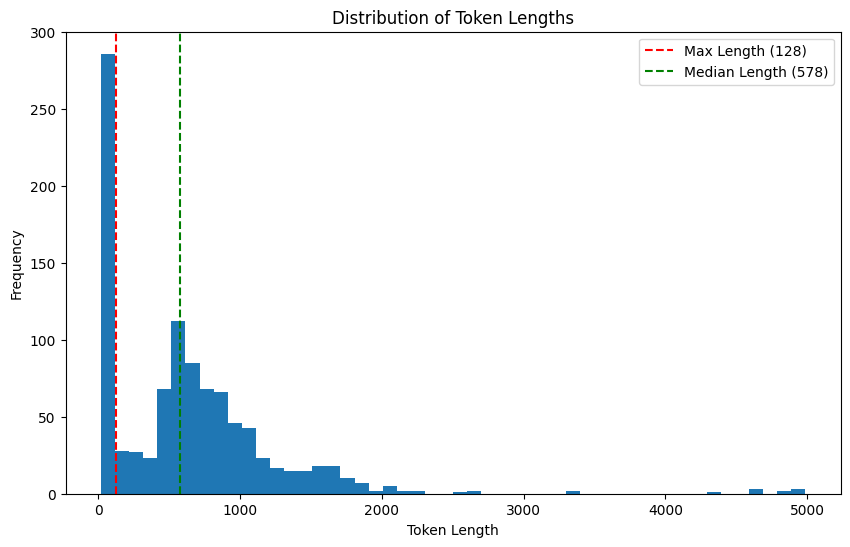

Median token length: 578.0
Mean token length: 648.444
Max token length: 4988
Percentage of samples longer than 128 tokens: 71.10%


In [15]:
tokenizer = AutoTokenizer.from_pretrained("ElKulako/cryptobert")

# Check the length of tokenized sequences
token_lengths = []
for text in tqdm(df['full_text'].sample(min(1000, len(df))).tolist()):
    tokens = tokenizer.encode(text)
    token_lengths.append(len(tokens))

# Plot histogram of token lengths
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50)
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Distribution of Token Lengths')
plt.axvline(x=128, color='r', linestyle='--', label='Max Length (128)')
plt.axvline(x=np.median(token_lengths), color='g', linestyle='--', label=f'Median Length ({np.median(token_lengths):.0f})')
plt.legend()
plt.show()

print(f"Median token length: {np.median(token_lengths)}")
print(f"Mean token length: {np.mean(token_lengths)}")
print(f"Max token length: {np.max(token_lengths)}")
print(f"Percentage of samples longer than 128 tokens: {sum(length > 128 for length in token_lengths) / len(token_lengths) * 100:.2f}%")


 Based on the token length analysis, we are now able to define the maximum sequence length for tokenization. The maintainer of the ElKulako/cryptobert model recommends using a max_length of 128 tokens.

In [16]:
MAX_LENGTH = 128

def tokenize_function(text):
    return tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors=None
    )

 ## Prepare Dataset for Fine-tuning

Sentiment values in the dataset:
sentiment
POSITIVE    7702
NEUTRAL     3899
NEGATIVE    3345
Name: count, dtype: int64

Label distribution:
label
2    7702
1    3899
0    3345
Name: count, dtype: int64
label
2    0.515322
1    0.260872
0    0.223806
Name: proportion, dtype: float64


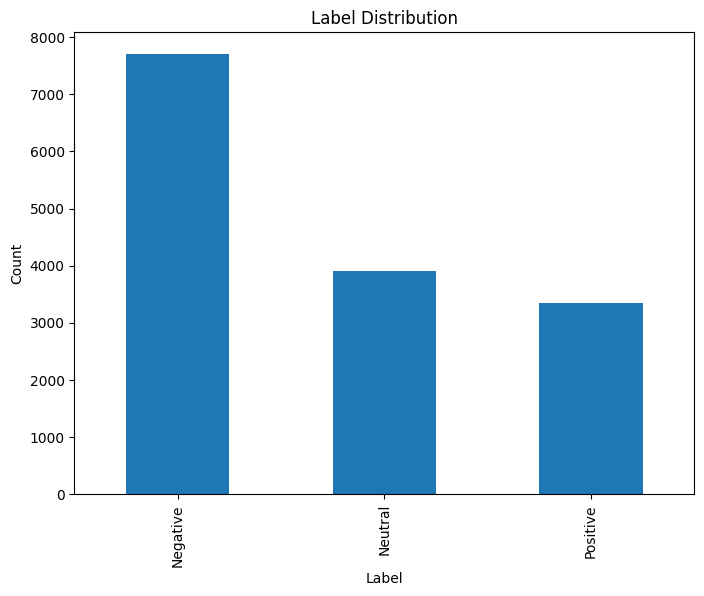

In [17]:
# Check available sentiment values
print("Sentiment values in the dataset:")
print(df['sentiment'].value_counts())

# Map sentiment to numerical labels
sentiment_map = {
    'NEGATIVE': 0,
    'NEUTRAL': 1,
    'POSITIVE': 2
}

# Create labels column
df['label'] = df['sentiment'].map(sentiment_map)

# Check label distribution
print("\nLabel distribution:")
print(df['label'].value_counts())
print(df['label'].value_counts(normalize=True))

# Plot the label distribution
plt.figure(figsize=(8, 6))
df['label'].value_counts().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.show()


 ## Splitting the dataset

In [18]:
# Create new dataframe with just the columns we need
data_df = df[['full_text', 'label']].copy()

train_df, temp_df = train_test_split(
    data_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=data_df['label']
)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=42, 
    stratify=temp_df['label']
)

print("Dataset splits:")
print(f"Train: {len(train_df)} samples")
print(f"Validation: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

Dataset splits:
Train: 11956 samples
Validation: 1495 samples
Test: 1495 samples


 ## Exporting processed datasets

In [19]:
train_df.to_csv("./data/processed_coindesk_train.csv", index=False)
val_df.to_csv("./data/processed_coindesk_val.csv", index=False)
test_df.to_csv("./data/processed_coindesk_test.csv", index=False)

print("Datasets saved to ./data/processed_coindesk_*.csv")

Datasets saved to ./data/processed_coindesk_*.csv
